# Интеллектуальный анализ данных – весна 2025
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.
* Если в задании есть вопрос на рассуждение, то за отсутствие ответа на него балл за задание будет снижен вполовину.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [2]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [12]:
df = pd.read_csv('tweets_coronavirus.csv', encoding='latin-1', on_bad_lines='warn')
df.sample(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
31961,43112,88064,Global,12-04-2020,"Virtual waiting rooms, such as @queueit, are h...",Positive
13146,19747,64699,"Catalonia, Spain",22-03-2020,Thanks to @amazon pantry! Their prices are 1/7...,Positive
30604,41436,86388,Nigeria,10-04-2020,How COVID-19 affected U.S. consumer prices in ...,Negative
26732,36579,81531,NaN,07-04-2020,This was a first! I've never had to walk into ...,Negative
23240,32197,77149,NaN,04-04-2020,Experience the only best online shopping Jus...,Extremely Positive
25341,34834,79786,Tunisian-Mediterranean,06-04-2020,#coronavirus #foodsecurity #covid19 \r\r\n1. M...,Negative
22504,31305,76257,"New Jersey, USA",03-04-2020,i been pumping out animated lyric videos crazy...,Negative
10459,16490,61442,"Pasadena, CA",21-03-2020,#BigAngryPhil #Podcast 153 will drop late toni...,Positive
23316,32287,77239,NaN,04-04-2020,PSA: They have plenty to do at your local groc...,Negative
25659,35224,80176,"Austin, TX",06-04-2020,About to make my first grocery store run in we...,Negative


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная или очень положительная эмоциональная окраска и 0 - если отрицательная или очень отрицательная.

In [13]:
sentiments = {
    'Positive': 1,
    'Extremely Positive': 1,
    'Negative': 0,
    'Extremely Negative': 0
}

df['Sentiment'] = df['Sentiment'].map(sentiments)
df.sample(10)


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
30652,41499,86451,"Milano, Bruxelles, Roma",10-04-2020,JUST Newsroom - COVID-19: Commissioner Reynder...,1
5372,10326,55278,"South Dublin, Ireland",19-03-2020,#coronavirus has caused global travel to colla...,0
32123,43316,88268,NaN,13-04-2020,Japanese are not yet in danger of coronavirus....,1
5092,9989,54941,la la land uk,19-03-2020,"If we are locked down we have tv,books, netfli...",1
1512,5631,50583,"League City, Texas",17-03-2020,Price gouging is illegal since Governor Abbott...,0
6423,11603,56555,Text RESIST to 50409,19-03-2020,? Support Erin by signing ÃÂCovid-19 Panic M...,0
20391,28680,73632,"Sidmouth, Devon",27-03-2020,Sid Vale food bank appeals for donations as co...,0
21195,29647,74599,Delaware,01-04-2020,People across the country are learning to cope...,0
8026,13552,58504,Vancouver Canada,20-03-2020,Huntsville leaders encourage residents to supp...,1
6936,12235,57187,NaN,19-03-2020,ppl be shitting on Asians hardcore now with al...,0


Сбалансированы ли классы?

In [14]:
counts = df['Sentiment'].value_counts()
print(counts)
print(counts[0] / counts[1])



Sentiment
1    18046
0    15398
Name: count, dtype: int64
0.8532638811925081


отношение кол-ва наблюдений - 0.85 / 1 => классы близки к балансу

**Ответ:** # -- YOUR ANSWER HERE --

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [15]:
print(df.isnull().sum())
df = df.fillna('Unknown')

print()
print(df.sample(6))

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

       UserName  ScreenName             Location     TweetAt  \
19102     27046       71998              Unknown  25-03-2020   
26679     36505       81457      London, England  07-04-2020   
6980      12287       57239  Birmingham, England  19-03-2020   
13513     20197       65149         Florida, USA  22-03-2020   
11323     17535       62487   Port Hope, Ontario  21-03-2020   
14965     21993       66945                  NYC  23-03-2020   

                                           OriginalTweet  Sentiment  
19102  Has #coronavirus affected your #ecommerce stor...          1  
26679  Consumer News ÃÂ #CitizensAdvice has respond...          1  
6980   Its sad really that as a society we pay vast a...          0  
13513  Does sanitizer help? What about masks? Dr. Mic...          1  
11323  One positive of isolation is that I have not s..

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и укажите `random_state=0`

In [16]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведения токенов в нижний регистр.

In [17]:

tokenized_texts = train['OriginalTweet'].apply(lambda x: x.lower().split())
tokens = {}

for text in tokenized_texts:
  for token in text:
    if token in tokens:
      tokens[token] += 1
    else:
      tokens[token] = 1



Какой размер словаря получился?

In [18]:
print('Размер словаря - ' + str(len(tokens)))

Размер словаря - 79755


Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе.

In [19]:

sorted_tokens = sorted(tokens, key = lambda x: tokens[x], reverse=True)
[(k, tokens[k]) for k in sorted_tokens[:10]]


[('the', 26815),
 ('to', 23373),
 ('and', 14684),
 ('of', 13012),
 ('a', 11737),
 ('in', 11198),
 ('for', 8566),
 ('#coronavirus', 8223),
 ('is', 7383),
 ('are', 7050)]

**Ответ:** Самые популярные токены - артикли и предлоги, так как они постоянно используются в письме, а так же хештэг коронавирус, так как выборка взята по теме коронавируса

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [20]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

filtered_tokens = {token: count for token, count in tokens.items() if token not in stop_words}
sorted_filtered_tokens = sorted(filtered_tokens, key = lambda x: tokens[x], reverse=True)
[(k, tokens[k]) for k in sorted_filtered_tokens[:10]]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[('#coronavirus', 8223),
 ('prices', 3891),
 ('food', 3820),
 ('grocery', 3469),
 ('supermarket', 3288),
 ('people', 3175),
 ('covid-19', 3173),
 ('store', 3155),
 ('#covid19', 2471),
 ('&amp;', 2314)]

**Ответ:** Токены, представленные в этом топе, уже отражают наиболее популярные темы обсуждения связанные с коронавирусом - рост цен, работа магазинов, однако, встречается и амперасанд и хэштэги, не несущие информации

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше, выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [21]:
[(k, tokens[k]) for k in sorted_filtered_tokens[-20:]]

[('skellig', 1),
 ('coast!', 1),
 ('closer!)', 1),
 ('@skelligsix18', 1),
 ('#skelligcoast2kms', 1),
 ('#southkerry', 1),
 ('https://t.co/zjcl195vqs', 1),
 ('@srinivasiyc', 1),
 ('https://t.co/iaek4fwsgz', 1),
 ('premiership', 1),
 ('non-playing', 1),
 ('subsidise', 1),
 ('playersã\x82â\x92', 1),
 ('renewing', 1),
 ('wage!', 1),
 ('flew', 1),
 ('nothing...', 1),
 ('@torontopearson', 1),
 ('@680news', 1),
 ('https://t.co/7j2y3rsld9', 1)]


**Ответ:** Эти токены представляют собой ссылки, слова со знаками препинания и узкоспециализированные редкие слова.

Редкие слова можно оставить в данных, остальное представляет из себя шум, так как не несет новой информации


Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [22]:
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer()
new_tokenized_texts = train['OriginalTweet'].apply(lambda x: tokenizer.tokenize(x.lower()))
new_tokens = {}

for text in new_tokenized_texts:
  for token in text:
    if token in new_tokens:
      new_tokens[token] += 1
    else:
      new_tokens[token] = 1

sorted_new_tokens = sorted(new_tokens, key = lambda x: new_tokens[x], reverse=True)

print('Новый топ')
print([(k, new_tokens[k]) for k in sorted_new_tokens[:10]])
print()
print('Старый топ')
print([(k, tokens[k]) for k in sorted_tokens[:10]])


Новый топ
[('the', 26993), ('.', 24118), ('to', 23478), (',', 17571), ('and', 14825), ('of', 13044), ('a', 11891), ('in', 11348), ('?', 9524), ('#coronavirus', 8808)]

Старый топ
[('the', 26815), ('to', 23373), ('and', 14684), ('of', 13012), ('a', 11737), ('in', 11198), ('for', 8566), ('#coronavirus', 8223), ('is', 7383), ('are', 7050)]


**Ответ:** В новом топе также обрабатываются знаки препинания, токенайзер учитывает слова и стоящие с ними вплотную знаки препинания как отдельные токены

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [23]:
from string import punctuation

filtered_new_tokens = {token: count for token, count in new_tokens.items() if token not in stop_words and token not in punctuation}
sorted_filtered_new_tokens = sorted(filtered_new_tokens, key = lambda x: new_tokens[x], reverse=True)
[(k, new_tokens[k]) for k in sorted_filtered_new_tokens[:10]]


[('#coronavirus', 8808),
 ('â', 7415),
 ('\x82', 7311),
 ('19', 7167),
 ('covid', 6253),
 ('prices', 4601),
 ('\x92', 4372),
 ('food', 4367),
 ('store', 3877),
 ('supermarket', 3805)]

**Ответ:**  Да, в топе появилось несколько нечитаемых символов

Скорее всего в некоторых топах были неотображаемые символы или отдельные буквы не латинского алфавита. Уберем их: удалите из словаря токены из одного символа, позиция которого в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [24]:
filtered_new_tokens = {k: v for k, v in filtered_new_tokens.items() if not(len(k) == 1 and ord(k) >= 128)}
sorted_filtered_new_tokens = sorted(filtered_new_tokens, key = lambda x: new_tokens[x], reverse=True)
[(k, new_tokens[k]) for k in sorted_filtered_new_tokens[:10]], [(k, new_tokens[k]) for k in sorted_filtered_new_tokens[-20:]]


([('#coronavirus', 8808),
  ('19', 7167),
  ('covid', 6253),
  ('prices', 4601),
  ('food', 4367),
  ('store', 3877),
  ('supermarket', 3805),
  ('grocery', 3523),
  ('people', 3463),
  ('#covid19', 2589)],
 [('https://t.co/lw1r0rm7xs', 1),
  ('https://t.co/5cbliqzx7l', 1),
  ('now.when', 1),
  ('milion', 1),
  ('skellig', 1),
  ('@skelligsix18', 1),
  ('#skelligcoast2kms', 1),
  ('#southkerry', 1),
  ('https://t.co/zjcl195vqs', 1),
  ('@srinivasiyc', 1),
  ('https://t.co/iaek4fwsgz', 1),
  ('premiership', 1),
  ('non-playing', 1),
  ('subsidise', 1),
  ('playersã', 1),
  ('renewing', 1),
  ('flew', 1),
  ('@torontopearson', 1),
  ('@680news', 1),
  ('https://t.co/7j2y3rsld9', 1)])

**Ответ:** В топ 10 стало меньше информации, так как токенайзер обрабатывает КОВИД-19 как 2 разных токен, однако, пропали специальные символы.

В топе напопулярных слов пропали слова стоящие вплотную с знаками препинания

Выведите топ-10 популярных хештегов (токены, первые символы которых - #) с количеством встреч. Что можно сказать о них?

In [25]:
hashtag_tokens = {k: v for k, v in filtered_new_tokens.items() if k[0] == '#'}
sorted_hashtag_tokens = sorted(hashtag_tokens, key = lambda x: hashtag_tokens[x], reverse=True)
[(k, hashtag_tokens[k]) for k in sorted_hashtag_tokens[:10]]

[('#coronavirus', 8808),
 ('#covid19', 2589),
 ('#covid_19', 1734),
 ('#covid2019', 946),
 ('#toiletpaper', 744),
 ('#covid', 641),
 ('#socialdistancing', 465),
 ('#coronacrisis', 448),
 ('#pandemic', 257),
 ('#coronaviruspandemic', 249)]

**Ответ:** Они показывают самые популярный темы постов по теме коронавируса

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [26]:
import re

link_tokens = {k: v for k, v in filtered_new_tokens.items() if re.match(r"https://t.co", k)}
sorted_link_tokens = sorted(link_tokens, key = lambda x: link_tokens[x], reverse=True)
[(k, link_tokens[k]) for k in sorted_link_tokens[:10]]


[('https://t.co/oxa7swtond', 5),
 ('https://t.co/gp3eusapl8', 4),
 ('https://t.co/deftrui1pfã\x82â', 3),
 ('https://t.co/wrlhyzizaa', 3),
 ('https://t.co/kuwipf1kqw', 3),
 ('https://t.co/zjnrx6dkkn', 3),
 ('https://t.co/3gbbdpdjat', 3),
 ('https://t.co/e2znxajpre', 3),
 ('https://t.co/catkegayoy', 3),
 ('https://t.co/g63rp042ho', 3)]

**Ответ:** Ссылки значительно менее популярны, а также имеют меньше повторений, так как одни разные пользователи редко используют ссылки на одни и те же ресурсы

Информация о ссылках полезна не будет

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для  выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа с позицией в таблице Unicode 128 и более,  ссылки на t.co



In [27]:

def token_is_valid(token):
  if token in stop_words or token in punctuation:
    return False

  if len(token) == 1 and ord(token) >= 128:
    return False

  if re.match(r'https://t.co', token):
    return False

  return True


def custom_tokenizer(text):

  text = text.lower()
  tokenizer = TweetTokenizer()
  tokens = [token for token in tokenizer.tokenize(text) if token_is_valid(token)]

  return tokens


In [28]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)
X_counts = cv.fit_transform(train['OriginalTweet'])

print('Новый результат: ' + str(len(cv.vocabulary_)))
print('Старый результат: ' + str(len(tokens)))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Новый результат: 45290
Старый результат: 79755


**Ответ:** # Словарь из задания 2 больше

Посмотрим на какой-нибудь конкретный твитт:

In [30]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 np.int64(0))

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [31]:

text = train.iloc[ind]['OriginalTweet']
vector = cv.transform([text])
print(vector)



<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 14 stored elements and shape (1, 45290)>
  Coords	Values
  (0, 1833)	1
  (0, 2046)	1
  (0, 16658)	1
  (0, 20553)	1
  (0, 26665)	1
  (0, 27042)	1
  (0, 27233)	1
  (0, 31570)	1
  (0, 34070)	1
  (0, 34679)	1
  (0, 35248)	1
  (0, 36404)	1
  (0, 37220)	1
  (0, 39909)	1


**Ответ:** Все токены получили значения 1, значит важность токенов опрпеделилась плохо. Явно негативный (brainlass) и явно позитивный (nice) получили одинаковые веса

В данном случае получилось, что все токены важны, так как твит очень краток и все токены встречаются там по одному разу

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
tfidf_vectorizer.fit(train['OriginalTweet'])
tfidf_vector = tfidf_vectorizer.transform([text])

vector_array = tfidf_vector.toarray()[0]
nonzero_indices = np.where(vector_array != 0)[0]
vector_array = sorted([(tfidf_vectorizer.get_feature_names_out()[i], vector_array[i])
                 for i in nonzero_indices], key=lambda x: x[1], reverse=True)
print(vector_array)

[('brainless', np.float64(0.3867641170466375)), ('queueing', np.float64(0.35434556333216544)), ('ffs', np.float64(0.3244741764513268)), ('france', np.float64(0.32047314046539654)), ('@skynews', np.float64(0.31042634466284263)), ('lets', np.float64(0.30121070136861045)), ('ppl', np.float64(0.2550064610386691)), ('nice', np.float64(0.2542729176022132)), ('show', np.float64(0.24406492401820118)), ('#coronavirusoutbreak', np.float64(0.22584265007428544)), ('#covid2019', np.float64(0.16825192939361902)), ('one', np.float64(0.16306722855395073)), ('panic', np.float64(0.14759470306326164)), ('food', np.float64(0.11328893069250721))]


**Ответ:** # Здесь веса токенов распределились более корректно, так как векторайзер учитывает частоту появления токенов в обучающем словаре

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [33]:
nice_tweets = train[train['OriginalTweet'].apply(lambda x: 'fabulous' in x) & (train['Sentiment'] == 1)]['OriginalTweet']

In [34]:
nice_tweet = nice_tweets.iloc[0]
nice_tweet

"We're open as usual tomorrow. We will remain constant and stable with our regular supplies of fabulous local produce. There's definitely no need to panic, the farmers and producers are always hard at work to ensure we have wonderful food and drinks! #InThisTogether #Covid_19 https://t.co/orvUeuUrb9"

In [35]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
tfidf_vectorizer.fit(train['OriginalTweet'])
tfidf_vector = tfidf_vectorizer.transform([nice_tweet])

vector_array = tfidf_vector.toarray()[0]
nonzero_indices = np.where(vector_array != 0)[0]
vector_array = sorted([(tfidf_vectorizer.get_feature_names_out()[i], vector_array[i])
                 for i in nonzero_indices], key=lambda x: x[1], reverse=True)
print(vector_array)

[('fabulous', np.float64(0.32143158262782884)), ('#inthistogether', np.float64(0.26588196758258414)), ('constant', np.float64(0.25163516468508657)), ('drinks', np.float64(0.25163516468508657)), ('wonderful', np.float64(0.24709004203022336)), ('stable', np.float64(0.23359394967189473)), ('definitely', np.float64(0.21812381114887655)), ('regular', np.float64(0.20825084411442418)), ('producers', np.float64(0.20745585618559859)), ('usual', np.float64(0.20307169465036548)), ("there's", np.float64(0.19834129556486316)), ('tomorrow', np.float64(0.19475475175609558)), ('remain', np.float64(0.18799338226482262)), ('farmers', np.float64(0.1855763538124254)), ('produce', np.float64(0.1855763538124254)), ('always', np.float64(0.18387972702555153)), ('ensure', np.float64(0.18351498363669927)), ('hard', np.float64(0.16912537610874162)), ('open', np.float64(0.16052146061128075)), ('supplies', np.float64(0.14975854716049347)), ('local', np.float64(0.1364641467897207)), ('work', np.float64(0.1326891272

**Ответ:** Для этого явно положительно окрашенного твита векторайзер выделяет положительные токены (fabulous, constant, wonderful)

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [36]:

cv = CountVectorizer(tokenizer=custom_tokenizer)
tv = TfidfVectorizer(tokenizer=custom_tokenizer)

X_count = cv.fit_transform(df['OriginalTweet'])
X_tfidf = tv.fit_transform(df['OriginalTweet'])
y = df['Sentiment'].values


Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

Используйте `sparse` матрицы (после векторизации), не превращайте их в `numpy.ndarray` или `pd.DataFrame` - может не хватить памяти.

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_train_count, X_test_count, y_train_count, y_test_count = train_test_split(X_count, y, test_size=0.3, random_state=66)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, test_size=0.3, random_state=66)

model_count = LogisticRegression(random_state=66)
model_tfidf = LogisticRegression(random_state=66)
model_count.fit(X_train_count, y_train_count)
model_tfidf.fit(X_train_tfidf, y_train_tfidf)

y_pred_train_count = model_count.predict(X_train_count)
y_pred_test_count = model_count.predict(X_test_count)
y_pred_train_tfidf = model_tfidf.predict(X_train_tfidf)
y_pred_test_tfidf = model_tfidf.predict(X_test_tfidf)

print("CountVectorizer:")
print(f'Обучающая выборка: {accuracy_score(y_train_count, y_pred_train_count)}')
print(f'Тестовая выборка: {accuracy_score(y_test_count, y_pred_test_count)}')
print()
print("TfidfVectorizer:")
print(f'Обучающая выборка: {accuracy_score(y_train_tfidf, y_pred_train_tfidf)}')
print(f'Тестовая выборка: {accuracy_score(y_test_tfidf, y_pred_test_tfidf)}')


CountVectorizer:
Обучающая выборка: 0.983596753524135
Тестовая выборка: 0.8738289814630257

TfidfVectorizer:
Обучающая выборка: 0.9231952157197779
Тестовая выборка: 0.8533984452860275


**Ответ:** Модель для которой был использован CountVectorizer, переобучилась, но показала незначительно лучшие результаты на тестовой выборке

В целом, модели показали схожие результаты, но можно сказать, что Tfidf справилась лучше, так как не слишком сильно подстраивалась под обучающие данные

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [38]:

from nltk.stem import SnowballStemmer


def token_is_valid(token):
  if token in stop_words or token in punctuation:
    return False

  if len(token) == 1 and ord(token) >= 128:
    return False

  if re.match(r'https://t.co', token):
    return False

  return True


def custom_stem_tokenizer(text):

  text = text.lower()
  tokenizer = TweetTokenizer('english')
  stemmer = SnowballStemmer('english')
  tokens = [stemmer.stem(token) for token in tokenizer.tokenize(text) if token_is_valid(token)]

  return tokens

In [39]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [40]:

cv2 = CountVectorizer(tokenizer=custom_stem_tokenizer)
tv2 = TfidfVectorizer(tokenizer=custom_stem_tokenizer)

X_count_stem = cv2.fit_transform(train['OriginalTweet'])
X_tfidf_stem = tv2.fit_transform(train['OriginalTweet'])


print(f'Резульататы без стемминга: {len(cv.vocabulary_)}, {len(tv.vocabulary_)}')
print(f'Результаты со стеммингом: {len(cv2.vocabulary_)}, {len(tv2.vocabulary_)}')

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Резульататы без стемминга: 56523, 56523
Результаты со стеммингом: 36634, 36634


**Ответ** Размер словаря при применении стемминга значительно уменьшается

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [41]:

X_c = cv2.transform(df['OriginalTweet'])
X_t = tv2.transform(df['OriginalTweet'])

X_train_count_stem, X_test_count_stem, y_train_count_stem, y_test_count_stem = train_test_split(X_c, y, test_size=0.3, random_state=66)
X_train_tfidf_stem, X_test_tfidf_stem, y_train_tfidf_stem, y_test_tfidf_stem = train_test_split(X_t, y, test_size=0.3, random_state=66)

model_count_stem = LogisticRegression(random_state=66)
model_tfidf_stem = LogisticRegression(random_state=66)

model_count_stem.fit(X_train_count_stem, y_train_count_stem)
model_tfidf_stem.fit(X_train_tfidf_stem, y_train_tfidf_stem)

y_pred_train_count_stem = model_count_stem.predict(X_train_count_stem)
y_pred_test_count_stem = model_count_stem.predict(X_test_count_stem)
y_pred_train_tfidf_stem = model_tfidf_stem.predict(X_train_tfidf_stem)
y_pred_test_tfidf_stem = model_tfidf_stem.predict(X_test_tfidf_stem)

print("CountVectorizer:")
print(f'Обучающая выборка: {accuracy_score(y_train_count_stem, y_pred_train_count_stem)}')
print(f'Тестовая выборка: {accuracy_score(y_test_count_stem, y_pred_test_count_stem)}')
print()
print("TfidfVectorizer:")
print(f'Обучающая выборка: {accuracy_score(y_train_tfidf_stem, y_pred_train_tfidf_stem)}')
print(f'Тестовая выборка: {accuracy_score(y_test_tfidf_stem, y_pred_test_tfidf_stem)}')


CountVectorizer:
Обучающая выборка: 0.9676633917129431
Тестовая выборка: 0.8666533785130556

TfidfVectorizer:
Обучающая выборка: 0.9137975224263135
Тестовая выборка: 0.8549930237193542


**Ответ:** Качество моделей улучшилось, значит, стемминг использовать стоит - он, улучшает качество модели и делает ее проще

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [42]:

print(len(cv2.vocabulary_))

cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=8000
                        ).fit(
                           train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

36634


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36633


**Ответ:** Параметр получился большим, так как max_df отвечает за частоту токенов, выше которой токены не учитываются. Получается, что самый популярный токен имеет частоту выше 8000, остальные - ниже

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [43]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=11
                        ).fit(
                            train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

3687


**Ответ:** Параметр получился маленьким, так как min_df отвечает за частоту токенов, ниже которой токены не учитываются.


В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `barplot`, содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


X_train = cv_df.fit_transform(train['OriginalTweet'])
X_test = cv_df.transform(test['OriginalTweet'])
y_train = train['Sentiment']
y_test = test['Sentiment']

scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LogisticRegression(random_state=66)
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)
print(f"Accuracy после нормализации: {accuracy_score(y_test, y_pred)}")


Accuracy после нормализации: 0.8447279250548136


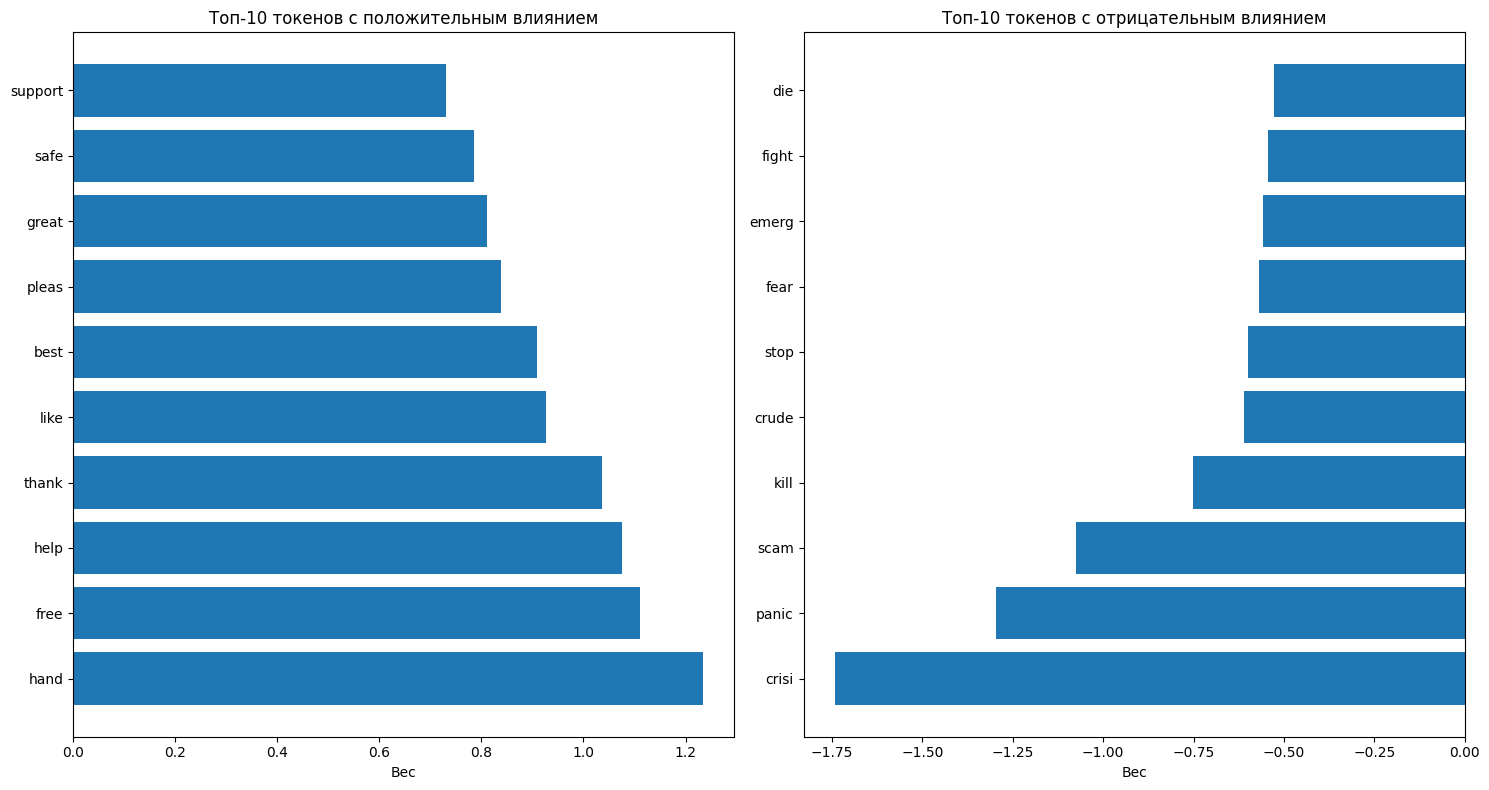

In [45]:
import matplotlib.pyplot as plt
import numpy as np

weights = lr.coef_[0]
feature_names = cv_df.get_feature_names_out()

top_positive = np.argsort(weights)[-10:][::-1]
top_negative = np.argsort(weights)[:10]

plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.barh(np.array([feature_names[i] for i in top_positive]),
        np.array([weights[i] for i in top_positive]))
plt.title("Топ-10 токенов с положительным влиянием")
plt.xlabel("Вес")

plt.subplot(1, 2, 2)
plt.barh(np.array([feature_names[i] for i in top_negative]),
        np.array([weights[i] for i in top_negative]))
plt.title("Топ-10 токенов с отрицательным влиянием")
plt.xlabel("Вес")

plt.tight_layout()
plt.show()

**Ответ:** Токены с большими положительными весами являются позитивными, а с большими отрицательными - негативными

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [46]:
print(f"Уникальных UserName: {train['UserName'].nunique()}")
print(f"Уникальных ScreenName: {train['ScreenName'].nunique()}")
print(f'Всего Твитов: {train["UserName"].shape[0]}')

Уникальных UserName: 23410
Уникальных ScreenName: 23410
Всего Твитов: 23410


**Ответ:** Кодирование этих признаков бесполезно, так как они все уникальны и не отражают суть твитов

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на основе целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

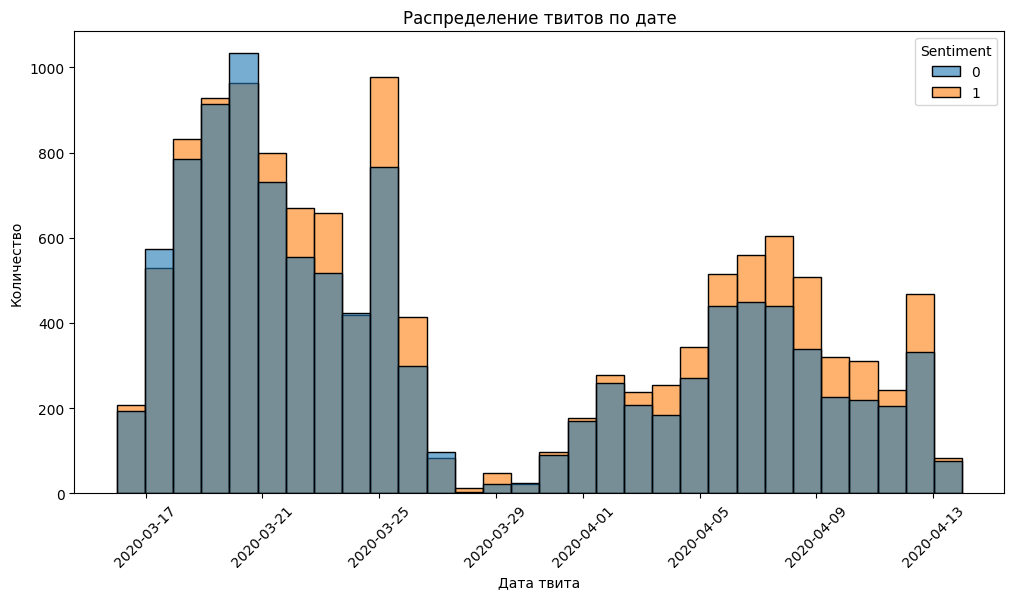

In [47]:
train['TweetAt'] = pd.to_datetime(train['TweetAt'], dayfirst=True)

plt.figure(figsize=(12, 6))
sns.histplot(
    data=train,
    x='TweetAt',
    hue='Sentiment',
    bins=30,
    alpha=0.6,
)
plt.title('Распределение твитов по дате')
plt.xlabel('Дата твита')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.show()

**Ответ:** Признак бесполезен, так как в разное время примерно одинаковое количество позитивных и негативных твитов



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [48]:
print(f'Уникальных локаций: {train["Location"].nunique()}')

Уникальных локаций: 7949


Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

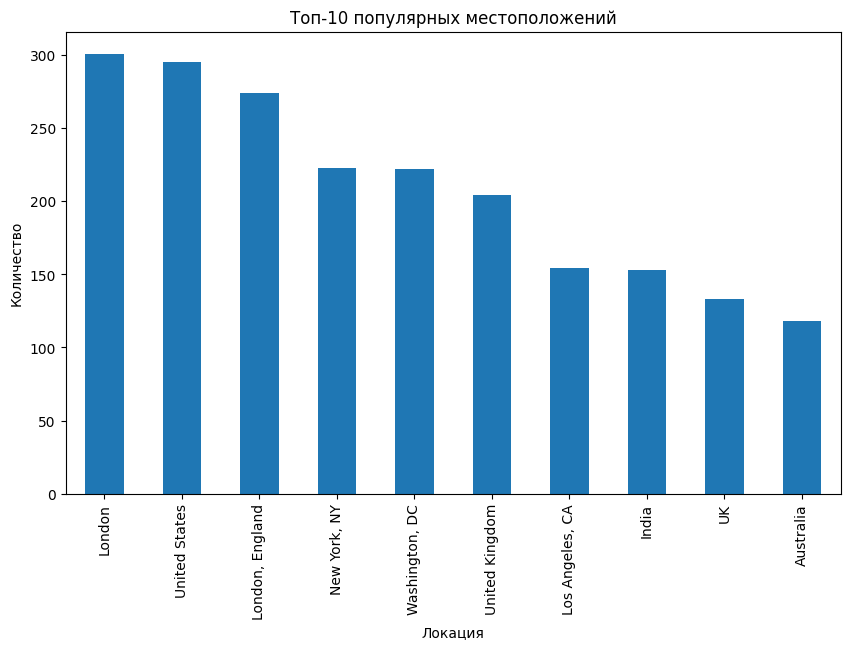

In [49]:

top_locations = train[train["Location"] != "Unknown"]["Location"].value_counts().head(10)

plt.figure(figsize=(10, 6))
top_locations.plot(kind="bar")
plt.title("Топ-10 популярных местоположений")
plt.xlabel("Локация")
plt.ylabel("Количество")
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [56]:
df["WiderLocation"] = df["Location"].str.split(",").str[-1].str.strip()
df["WiderLocation"] = df["WiderLocation"].replace("", "Unknown").replace("unknown", "Unknown")

print(f'Уникальных широких местоположений: {train["WiderLocation"].nunique()}')

Уникальных широких местоположений: 4630


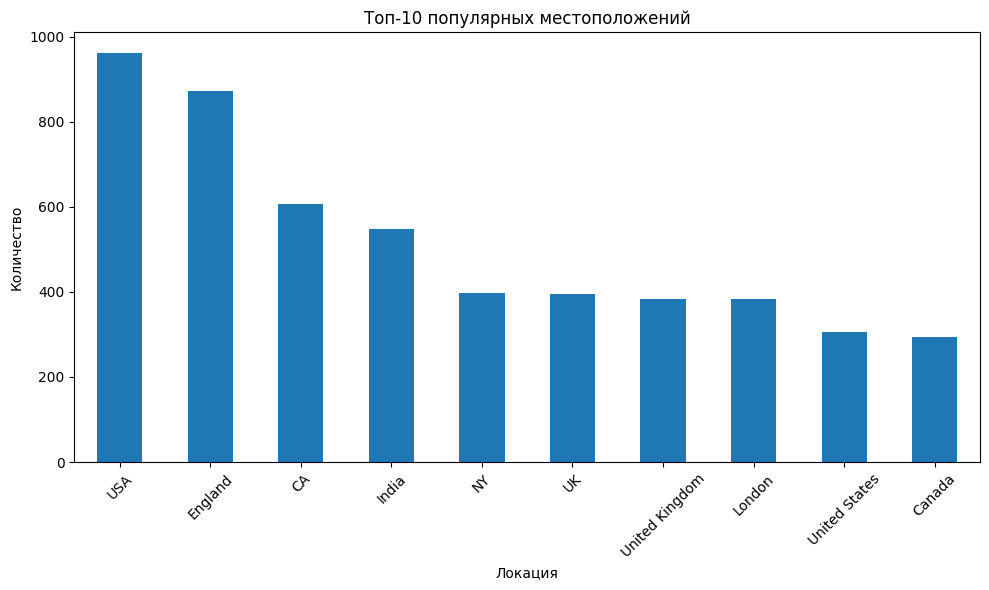

In [57]:
wider = train[train["WiderLocation"] != "Unknown"]["WiderLocation"].value_counts().head(10)

plt.figure(figsize=(10, 6))
wider.plot(kind="bar")
plt.title("Топ-10 популярных местоположений")
plt.xlabel("Локация")
plt.ylabel("Количество")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [58]:

from sklearn.preprocessing import OneHotEncoder

train["WiderLocation"] = train["Location"].str.split(",").str[-1].str.strip()
train["WiderLocation"] = train["WiderLocation"].replace("", "Unknown").replace("unknown", "Unknown")
test["WiderLocation"] = test["Location"].str.split(",").str[-1].str.strip()
test["WiderLocation"] = test["WiderLocation"].replace("", "Unknown").replace("unknown", "Unknown")

location_counts = train["WiderLocation"].value_counts()
valid_locations = location_counts[location_counts > 1].index.tolist()
print(f"Количество локаций, встречающихся более 1 раза: {len(valid_locations)}")

encoder = OneHotEncoder(categories=[valid_locations], handle_unknown='ignore', sparse_output=True)
ohe_loc_train = encoder.fit_transform(train[['WiderLocation']])
ohe_loc_test = encoder.fit_transform(test[['WiderLocation']])

Количество локаций, встречающихся более 1 раза: 987


Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [59]:

from scipy.sparse import hstack

X_train_text = cv_df.fit_transform(train['OriginalTweet'])
X_test_text = cv_df.transform(test['OriginalTweet'])
y_train = train['Sentiment']
y_test = test['Sentiment']

scaler = StandardScaler(with_mean=False)
X_train_text_scaled = scaler.fit_transform(X_train_text)
X_test_text_scaled = scaler.transform(X_test_text)

X_train_full = hstack([X_train_text_scaled, ohe_loc_train])
X_test_full = hstack([X_test_text_scaled, ohe_loc_test])

lr = LogisticRegression(random_state=66)
lr.fit(X_train_full, y_train)

y_pred_train = lr.predict(X_train_full)
y_pred_test = lr.predict(X_test_full)
print(f"Accuracy на тренировочной выборке: {accuracy_score(y_train, y_pred_train)}")
print(f"Accuracy на тестовой выборке: {accuracy_score(y_test, y_pred_test)}")


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy на тренировочной выборке: 0.9448526270824434
Accuracy на тестовой выборке: 0.8448275862068966


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Ответ:** Качество модели почти не изменилось, значит, признак оказался бесполезным